In [269]:
import pandas as pd
import numpy as np

In [270]:
#import the data
import pickle
with open('raw_data.pkl', 'rb') as fp:
    raw_data = pickle.load(fp)

features_basic = list(raw_data.columns)
print(features_basic)

['LAT', 'LON', 'YEAR', 'MONTH', 'DAY', 'T2M_RANGE', 'T2M', 'RH2M', 'PS', 'WS50M', 'WS10M', 'WS50M_RANGE', 'WS10M_RANGE', 'ALLSKY_SFC_SW_DWN', 'DAY_OF_YEAR', 'SEASONAL', 'T2M_diff']


In this test I'll try  to compare a few different combinations of features and models

In [271]:
#create n prior days and 2 future days for T2M


#reset indexes
raw_data = raw_data.reset_index()
raw_data = raw_data.drop(['index'], axis=1)


def derive_nth_day_feature(df, feature, N):
    rows = df.shape[0]
    nth_prior_measurements = [None]*N + [df[feature][i-N] for i in range(N, rows)]
    col_name = "{}_{}".format(feature, N)
    df[col_name] = nth_prior_measurements

def add_nth_day_feature(df, feature, N): #thesame as above, but in other way, for T2M in future days
    rows = df.shape[0]
    nth_prior_measurements = [df[feature][i+N] for i in range(0, rows-N)] + [None]*N
    col_name = "{}_future_{}".format(feature, N)
    df[col_name] = nth_prior_measurements

for feature in features_basic: ## 3 days into past
    if not feature in ['LAT', 'LON', 'YEAR', 'MONTH', 'DAY', 'DAY_OF_YEAR']:
        print(feature)

        for N in range(1, 4):
            derive_nth_day_feature(raw_data, feature, N)

#add T2M 2 days in future
for N in range(1, 3):
    add_nth_day_feature(raw_data, 'T2M', N)

#drop NA
raw_data = raw_data.dropna()

#reset indexes
raw_data = raw_data.reset_index()
raw_data = raw_data.drop(['index'], axis=1)

print(raw_data.columns)


T2M_RANGE
T2M
RH2M
PS
WS50M
WS10M
WS50M_RANGE
WS10M_RANGE
ALLSKY_SFC_SW_DWN
SEASONAL
T2M_diff
Index(['LAT', 'LON', 'YEAR', 'MONTH', 'DAY', 'T2M_RANGE', 'T2M', 'RH2M', 'PS',
       'WS50M', 'WS10M', 'WS50M_RANGE', 'WS10M_RANGE', 'ALLSKY_SFC_SW_DWN',
       'DAY_OF_YEAR', 'SEASONAL', 'T2M_diff', 'T2M_RANGE_1', 'T2M_RANGE_2',
       'T2M_RANGE_3', 'T2M_1', 'T2M_2', 'T2M_3', 'RH2M_1', 'RH2M_2', 'RH2M_3',
       'PS_1', 'PS_2', 'PS_3', 'WS50M_1', 'WS50M_2', 'WS50M_3', 'WS10M_1',
       'WS10M_2', 'WS10M_3', 'WS50M_RANGE_1', 'WS50M_RANGE_2', 'WS50M_RANGE_3',
       'WS10M_RANGE_1', 'WS10M_RANGE_2', 'WS10M_RANGE_3',
       'ALLSKY_SFC_SW_DWN_1', 'ALLSKY_SFC_SW_DWN_2', 'ALLSKY_SFC_SW_DWN_3',
       'SEASONAL_1', 'SEASONAL_2', 'SEASONAL_3', 'T2M_diff_1', 'T2M_diff_2',
       'T2M_diff_3', 'T2M_future_1', 'T2M_future_2'],
      dtype='object')


In [272]:
#save the data with additional parameters
data_past_features_3_days_future = raw_data
import pickle
with open('data_past_features_3_days_future.pkl', 'wb') as fp:
    pickle.dump(data_past_features_3_days_future, fp)


# data with features with correlation to "T2M" > 50%


In [350]:
# Create datasets
all_features = list(raw_data.columns)
target = ['T2M', 'T2M_future_1', 'T2M_future_2']

#data all features with corr > 50% to "T2M"
correlation_value = 0.5
data_high_corr = pd.DataFrame()
for feature in all_features:
    if not feature in features_basic + ['T2M_future_1', 'T2M_future_2']: #get useful data
        if abs(raw_data.corr()['T2M'][feature]) > correlation_value or\
                abs(raw_data.corr()['T2M_future_1'][feature]) > correlation_value or\
                abs(raw_data.corr()['T2M_future_2'][feature]) > correlation_value:
            data_high_corr[feature] = raw_data[feature]

data_high_corr_features = data_high_corr.columns

for feature in ['T2M', 'T2M_future_1', 'T2M_future_2']:
    data_high_corr[feature] = raw_data[feature]


data_high_corr.head()


# last = 'T2M_RANGE', 'RH2M', 'SEASONAL',

,T2M_RANGE_1,T2M_RANGE_2,T2M_RANGE_3,T2M_1,T2M_2,T2M_3,RH2M_1,RH2M_2,RH2M_3,SEASONAL_1,SEASONAL_2,SEASONAL_3,T2M,T2M_future_1,T2M_future_2
0,2.93,2.99,4.27,-0.07,1.21,-0.16,85.74,86.11,90.06,-13.379881,-13.699840,-12.613052,-1.14,-7.49,-10.71
1,3.39,2.93,2.99,-1.14,-0.07,1.21,83.99,85.74,86.11,-12.268491,-13.379881,-13.699840,-7.49,-10.71,-6.52
2,11.54,3.39,2.93,-7.49,-1.14,-0.07,73.39,83.99,85.74,-12.955052,-12.268491,-13.379881,-10.71,-6.52,0.34
3,7.63,11.54,3.39,-10.71,-7.49,-1.14,73.49,73.39,83.99,-15.109025,-12.955052,-12.268491,-6.52,0.34,3.38
4,5.13,7.63,11.54,-6.52,-10.71,-7.49,79.12,73.49,73.39,-16.209470,-15.109025,-12.955052,0.34,3.38,1.05


check for linearity between features_basic and T2M

Index(['T2M_RANGE_1', 'T2M_RANGE_2', 'T2M_RANGE_3', 'T2M_1', 'T2M_2', 'T2M_3',
       'RH2M_1', 'RH2M_2', 'RH2M_3', 'SEASONAL_1', 'SEASONAL_2', 'SEASONAL_3'],
      dtype='object')


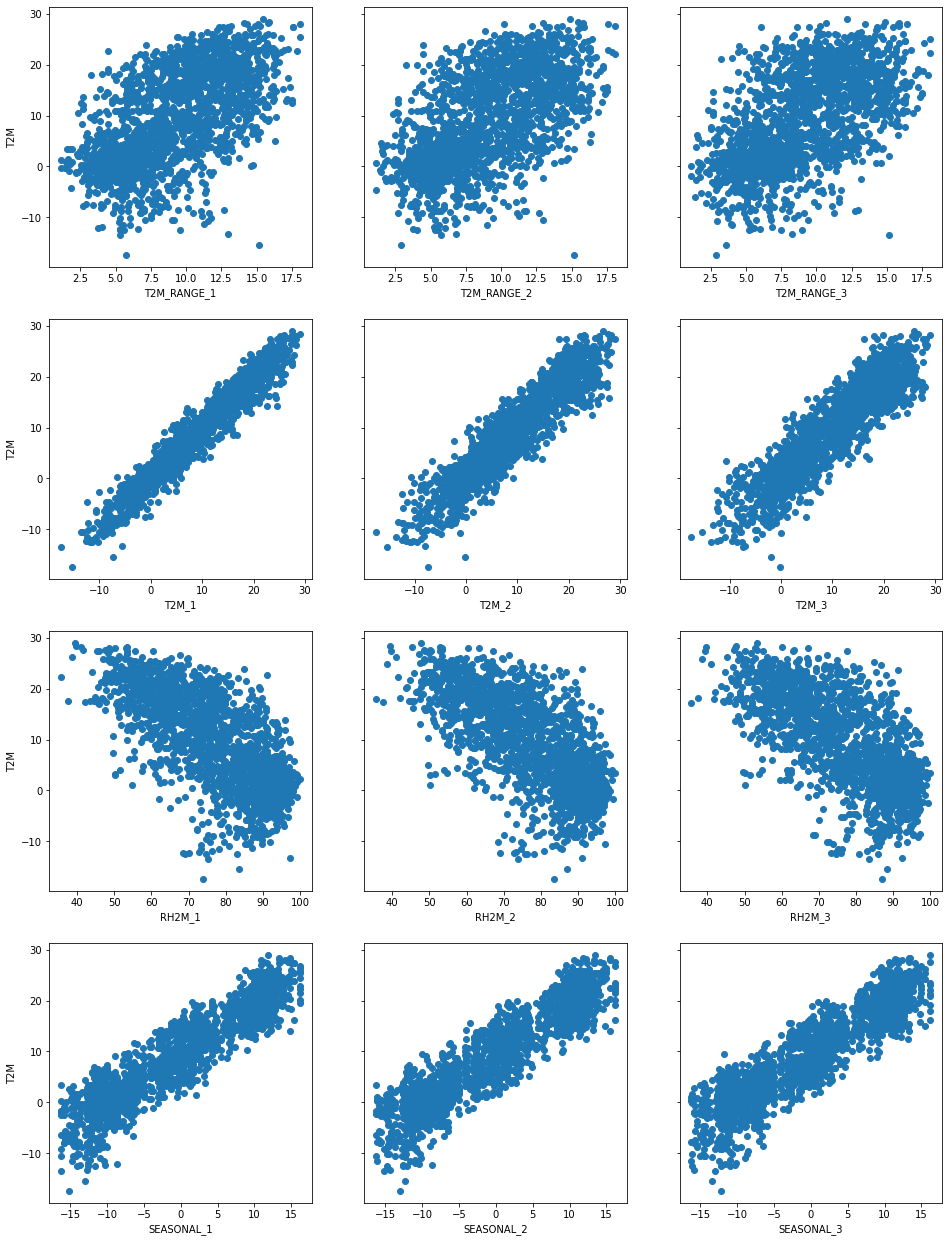

In [351]:
import matplotlib.pyplot as plt
%matplotlib inline

print(data_high_corr_features)
# manually set the parameters of the figure to and appropriate size
plt.rcParams['figure.figsize'] = [16, 22]

# call subplots specifying the grid structure we desire and that
# the y axes should be shared
fig, axes = plt.subplots(nrows=4, ncols=3, sharey=True)

# Since it would be nice to loop through the features in to build this plot
# let us rearrange our data into a 2D array of 6 rows and 3 columns
arr = np.array(data_high_corr_features).reshape(4, 3)

# use enumerate to loop over the arr 2D array of rows and columns
# and create scatter plots of each meantempm vs each feature
for row, col_arr in enumerate(arr):
    for col, feature in enumerate(col_arr):
        axes[row, col].scatter(data_high_corr[feature], data_high_corr['T2M'])
        if col == 0:
            axes[row, col].set(xlabel=feature, ylabel='T2M')
        else:
            axes[row, col].set(xlabel=feature)
plt.show()


we can see we have nice linear correlation, only RH2M isn't slim shape

# correlated parameters model, no regularization / lasso/ ridge / elasticnet

In [352]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

X = data_high_corr[data_high_corr_features]
Y = data_high_corr[target]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=12)


linear = LinearRegression(normalize=False)
linear.fit(X_train, Y_train)

Y_hat = linear.predict(X_test)


print('results for features_basic:', *data_high_corr_features)
print("The Explained Variance: %.2f" % linear.score(X_test, Y_test))
print("The Mean Absolute Error overall: %.2f degrees celsius" % mean_absolute_error(Y_test, Y_hat))

print('\n1 day prediction errors:')
print("The Mean Absolute Error: %.2f degrees celsius" % mean_absolute_error([x[0] for x in Y_hat], Y_test["T2M"]))

print('\n2 day prediction errors:')
print("The Mean Absolute Error: %.2f degrees celsius" % mean_absolute_error([x[1] for x in Y_hat], Y_test["T2M_future_1"]))

print('\n3 day prediction errors:')
print("The Mean Absolute Error: %.2f degrees celsius" % mean_absolute_error([x[2] for x in Y_hat], Y_test["T2M_future_2"]))

results for features_basic: T2M_RANGE_1 T2M_RANGE_2 T2M_RANGE_3 T2M_1 T2M_2 T2M_3 RH2M_1 RH2M_2 RH2M_3 SEASONAL_1 SEASONAL_2 SEASONAL_3
The Explained Variance: 0.91
The Mean Absolute Error overall: 2.18 degrees celsius

1 day prediction errors:
The Mean Absolute Error: 1.45 degrees celsius

2 day prediction errors:
The Mean Absolute Error: 2.40 degrees celsius

3 day prediction errors:
The Mean Absolute Error: 2.70 degrees celsius


c:\users\emilian rejman\appdata\local\programs\python\python37\lib\site-packages\sklearn\base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


rdige

In [353]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=2)
ridge.fit(X_train, Y_train)
Y_hat = ridge.predict(X_test)

print('results for features_basic:', *data_high_corr_features)
print("The Explained Variance: %.2f" % ridge.score(X_test, Y_test))
print("The Mean Absolute Error overall: %.2f degrees celsius" % mean_absolute_error(Y_test, Y_hat))

print('\n1 day prediction errors:')
print("The Mean Absolute Error: %.2f degrees celsius" % mean_absolute_error([x[0] for x in Y_hat], Y_test["T2M"]))

print('\n2 day prediction errors:')
print("The Mean Absolute Error: %.2f degrees celsius" % mean_absolute_error([x[1] for x in Y_hat], Y_test["T2M_future_1"]))

print('\n3 day prediction errors:')
print("The Mean Absolute Error: %.2f degrees celsius" % mean_absolute_error([x[2] for x in Y_hat], Y_test["T2M_future_2"]))

results for features_basic: T2M_RANGE_1 T2M_RANGE_2 T2M_RANGE_3 T2M_1 T2M_2 T2M_3 RH2M_1 RH2M_2 RH2M_3 SEASONAL_1 SEASONAL_2 SEASONAL_3
The Explained Variance: 0.91
The Mean Absolute Error overall: 2.18 degrees celsius

1 day prediction errors:
The Mean Absolute Error: 1.45 degrees celsius

2 day prediction errors:
The Mean Absolute Error: 2.40 degrees celsius

3 day prediction errors:
The Mean Absolute Error: 2.70 degrees celsius


c:\users\emilian rejman\appdata\local\programs\python\python37\lib\site-packages\sklearn\base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


In [355]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.1)
lasso.fit(X_train, Y_train)
Y_hat = lasso.predict(X_test)

print('results for features_basic:', *data_high_corr_features)
print("The Explained Variance: %.2f" % lasso.score(X_test, Y_test))
print("The Mean Absolute Error overall: %.2f degrees celsius" % mean_absolute_error(Y_test, Y_hat))

print('\n1 day prediction errors:')
print("The Mean Absolute Error: %.2f degrees celsius" % mean_absolute_error([x[0] for x in Y_hat], Y_test["T2M"]))

print('\n2 day prediction errors:')
print("The Mean Absolute Error: %.2f degrees celsius" % mean_absolute_error([x[1] for x in Y_hat], Y_test["T2M_future_1"]))

print('\n3 day prediction errors:')
print("The Mean Absolute Error: %.2f degrees celsius" % mean_absolute_error([x[2] for x in Y_hat], Y_test["T2M_future_2"]))

results for features_basic: T2M_RANGE_1 T2M_RANGE_2 T2M_RANGE_3 T2M_1 T2M_2 T2M_3 RH2M_1 RH2M_2 RH2M_3 SEASONAL_1 SEASONAL_2 SEASONAL_3
The Explained Variance: 0.91
The Mean Absolute Error overall: 2.18 degrees celsius

1 day prediction errors:
The Mean Absolute Error: 1.45 degrees celsius

2 day prediction errors:
The Mean Absolute Error: 2.39 degrees celsius

3 day prediction errors:
The Mean Absolute Error: 2.69 degrees celsius


c:\users\emilian rejman\appdata\local\programs\python\python37\lib\site-packages\sklearn\base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


In [356]:
from sklearn.linear_model import ElasticNet

elnet = ElasticNet(alpha=0.2, l1_ratio=0.1)
elnet.fit(X_train, Y_train)
Y_hat = elnet.predict(X_test)

print('results for features_basic:', *data_high_corr_features)
print("The Explained Variance: %.2f" % elnet.score(X_test, Y_test))
print("The Mean Absolute Error overall: %.2f degrees celsius" % mean_absolute_error(Y_test, Y_hat))

print('\n1 day prediction errors:')
print("The Mean Absolute Error: %.2f degrees celsius" % mean_absolute_error([x[0] for x in Y_hat], Y_test["T2M"]))

print('\n2 day prediction errors:')
print("The Mean Absolute Error: %.2f degrees celsius" % mean_absolute_error([x[1] for x in Y_hat], Y_test["T2M_future_1"]))

print('\n3 day prediction errors:')
print("The Mean Absolute Error: %.2f degrees celsius" % mean_absolute_error([x[2] for x in Y_hat], Y_test["T2M_future_2"]))

results for features_basic: T2M_RANGE_1 T2M_RANGE_2 T2M_RANGE_3 T2M_1 T2M_2 T2M_3 RH2M_1 RH2M_2 RH2M_3 SEASONAL_1 SEASONAL_2 SEASONAL_3
The Explained Variance: 0.91
The Mean Absolute Error overall: 2.18 degrees celsius

1 day prediction errors:
The Mean Absolute Error: 1.46 degrees celsius

2 day prediction errors:
The Mean Absolute Error: 2.39 degrees celsius

3 day prediction errors:
The Mean Absolute Error: 2.70 degrees celsius


c:\users\emilian rejman\appdata\local\programs\python\python37\lib\site-packages\sklearn\base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


# data with all features


In [357]:
# data with all parameters
X = pd.DataFrame()
Y = pd.DataFrame()
for feature in raw_data.columns:
    if not feature in features_basic + ['T2M_future_1', 'T2M_future_2']: #get useful data
        X[feature] = raw_data[feature]


for feature in target:
    Y[feature] = raw_data[feature]

print(X.columns, Y.columns)

Index(['T2M_RANGE_1', 'T2M_RANGE_2', 'T2M_RANGE_3', 'T2M_1', 'T2M_2', 'T2M_3',
       'RH2M_1', 'RH2M_2', 'RH2M_3', 'PS_1', 'PS_2', 'PS_3', 'WS50M_1',
       'WS50M_2', 'WS50M_3', 'WS10M_1', 'WS10M_2', 'WS10M_3', 'WS50M_RANGE_1',
       'WS50M_RANGE_2', 'WS50M_RANGE_3', 'WS10M_RANGE_1', 'WS10M_RANGE_2',
       'WS10M_RANGE_3', 'ALLSKY_SFC_SW_DWN_1', 'ALLSKY_SFC_SW_DWN_2',
       'ALLSKY_SFC_SW_DWN_3', 'SEASONAL_1', 'SEASONAL_2', 'SEASONAL_3',
       'T2M_diff_1', 'T2M_diff_2', 'T2M_diff_3'],
      dtype='object') Index(['T2M', 'T2M_future_1', 'T2M_future_2'], dtype='object')


In [358]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=12)

ridge = Ridge(alpha=0.1)
ridge.fit(X_train, Y_train)

Y_hat = ridge.predict(X_test)

from sklearn.metrics import mean_absolute_error, median_absolute_error
print('results for features_basic:', *X.columns)
print("The Explained Variance: %.2f" % ridge.score(X_test, Y_test))
print("The Mean Absolute Error overall: %.2f degrees celsius" % mean_absolute_error(Y_test, Y_hat))

print('\n1 day prediction errors:')
print("The Mean Absolute Error: %.2f degrees celsius" % mean_absolute_error([x[0] for x in Y_hat], Y_test["T2M"]))

print('\n2 day prediction errors:')
print("The Mean Absolute Error: %.2f degrees celsius" % mean_absolute_error([x[1] for x in Y_hat], Y_test["T2M_future_1"]))

print('\n3 day prediction errors:')
print("The Mean Absolute Error: %.2f degrees celsius" % mean_absolute_error([x[2] for x in Y_hat], Y_test["T2M_future_2"]))

results for features_basic: T2M_RANGE_1 T2M_RANGE_2 T2M_RANGE_3 T2M_1 T2M_2 T2M_3 RH2M_1 RH2M_2 RH2M_3 PS_1 PS_2 PS_3 WS50M_1 WS50M_2 WS50M_3 WS10M_1 WS10M_2 WS10M_3 WS50M_RANGE_1 WS50M_RANGE_2 WS50M_RANGE_3 WS10M_RANGE_1 WS10M_RANGE_2 WS10M_RANGE_3 ALLSKY_SFC_SW_DWN_1 ALLSKY_SFC_SW_DWN_2 ALLSKY_SFC_SW_DWN_3 SEASONAL_1 SEASONAL_2 SEASONAL_3 T2M_diff_1 T2M_diff_2 T2M_diff_3
The Explained Variance: 0.91
The Mean Absolute Error overall: 2.16 degrees celsius

1 day prediction errors:
The Mean Absolute Error: 1.47 degrees celsius

2 day prediction errors:
The Mean Absolute Error: 2.37 degrees celsius

3 day prediction errors:
The Mean Absolute Error: 2.65 degrees celsius


c:\users\emilian rejman\appdata\local\programs\python\python37\lib\site-packages\sklearn\base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


manual features extraction

In [359]:
extract = [ 'T2M_diff_1', 'T2M_diff_2', 'T2M_diff_3', 'WS10M_1', 'WS10M_2', 'WS10M_3', 'T2M_1', 'T2M_2', 'T2M_3']
X = pd.DataFrame()
Y = pd.DataFrame()
for feature in raw_data.columns:
    if feature in extract: #get useful data
        X[feature] = raw_data[feature]


for feature in target:
    Y[feature] = raw_data[feature]

print(X.columns, Y.columns)

Index(['T2M_1', 'T2M_2', 'T2M_3', 'WS10M_1', 'WS10M_2', 'WS10M_3',
       'T2M_diff_1', 'T2M_diff_2', 'T2M_diff_3'],
      dtype='object') Index(['T2M', 'T2M_future_1', 'T2M_future_2'], dtype='object')


In [360]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=12)

ridge = Ridge(alpha=0.1)
ridge.fit(X_train, Y_train)

Y_hat = ridge.predict(X_test)

from sklearn.metrics import mean_absolute_error, median_absolute_error
print('results for features_basic:', *X.columns)
print("The Explained Variance: %.2f" % ridge.score(X_test, Y_test))
print("The Mean Absolute Error overall: %.2f degrees celsius" % mean_absolute_error(Y_test, Y_hat))

print('\n1 day prediction errors:')
print("The Mean Absolute Error: %.2f degrees celsius" % mean_absolute_error([x[0] for x in Y_hat], Y_test["T2M"]))

print('\n2 day prediction errors:')
print("The Mean Absolute Error: %.2f degrees celsius" % mean_absolute_error([x[1] for x in Y_hat], Y_test["T2M_future_1"]))

print('\n3 day prediction errors:')
print("The Mean Absolute Error: %.2f degrees celsius" % mean_absolute_error([x[2] for x in Y_hat], Y_test["T2M_future_2"]))



results for features_basic: T2M_1 T2M_2 T2M_3 WS10M_1 WS10M_2 WS10M_3 T2M_diff_1 T2M_diff_2 T2M_diff_3
The Explained Variance: 0.90
The Mean Absolute Error overall: 2.31 degrees celsius

1 day prediction errors:
The Mean Absolute Error: 1.52 degrees celsius

2 day prediction errors:
The Mean Absolute Error: 2.54 degrees celsius

3 day prediction errors:
The Mean Absolute Error: 2.87 degrees celsius


c:\users\emilian rejman\appdata\local\programs\python\python37\lib\site-packages\sklearn\base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


# Conlcusion

Manual separation of the data gave the worst results, we shouldn't pick features only on our feelings.

Results from data with features with covariance to T2M > 50% gave us just slightly wors results (by 0,02*C) then
LL on all features, thats why we can say these few parameters carries the most linear knowledge about the target.